In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
plt.style.use(['science', 'grid'])
plt.rcParams["figure.dpi"] = 150

In [366]:
R_E = 6378

data = np.load('../exploration/final_2_110.npz')
x = data['x']
u= data['u']

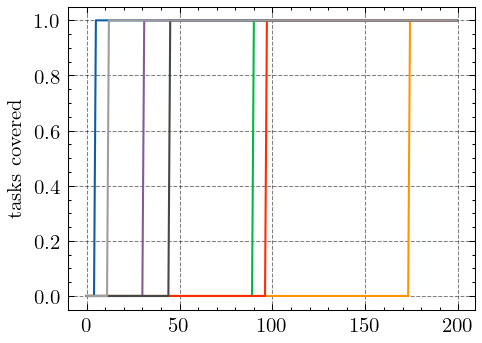

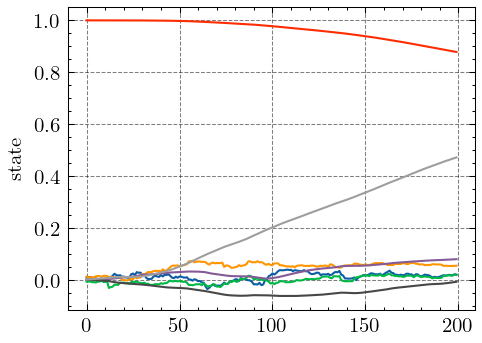

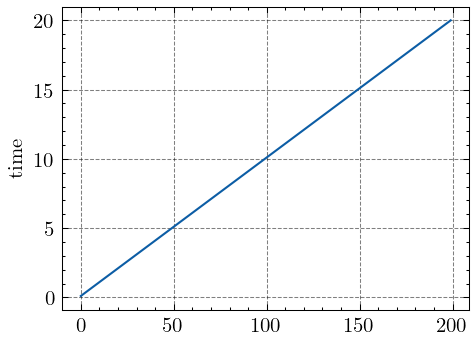

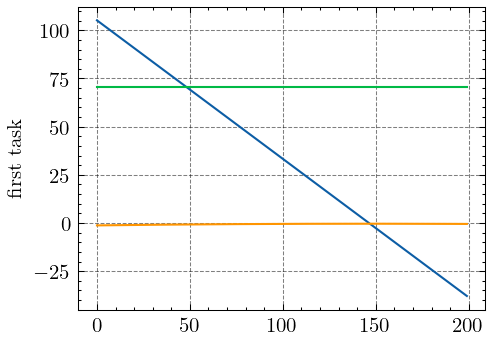

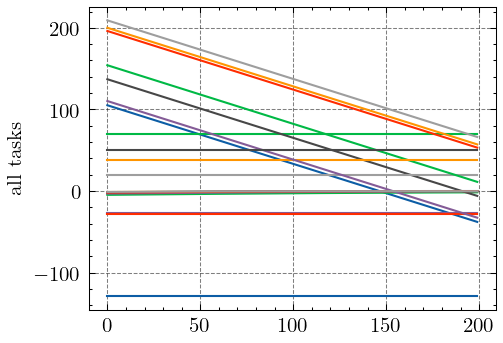

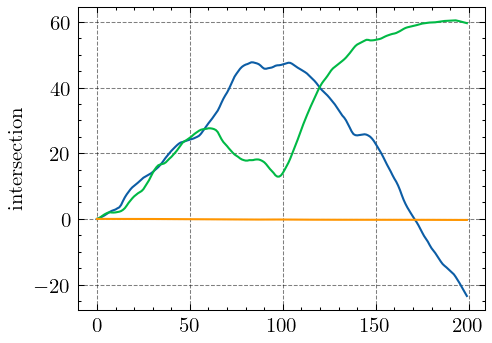

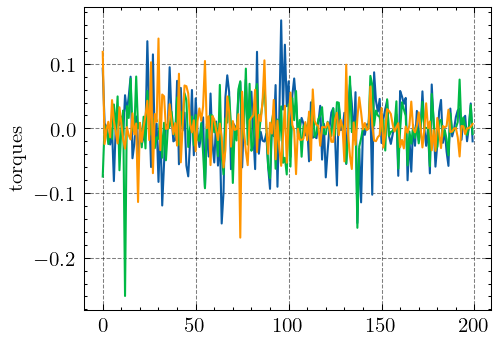

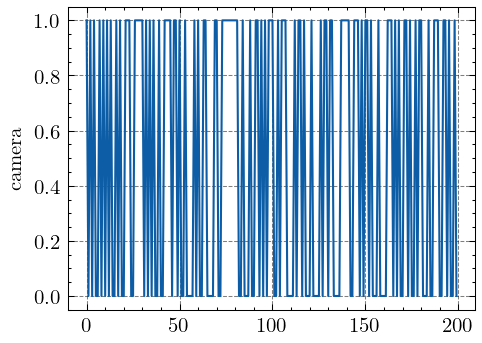

[1.0000001  1.0000001  1.         1.         1.         1.
 1.         1.         0.99999994 0.99999994 0.9999999  0.99999994
 1.         0.99999994 0.99999994 1.         1.         1.
 1.         1.0000002  1.0000001  1.0000001  1.0000001  1.0000002
 1.0000001  1.0000001  1.0000001  1.0000001  1.0000001  1.0000001
 1.0000001  1.0000001  1.0000001  1.0000001  1.0000002  1.0000001
 1.0000001  1.0000001  1.0000001  1.0000001  1.0000001  1.0000002
 1.0000002  1.0000002  1.0000002  1.0000002  1.0000002  1.0000001
 1.0000001  1.0000001  1.0000002  1.0000001  1.0000001  1.0000002
 1.0000002  1.0000001  1.0000002  1.0000002  1.0000002  1.0000004
 1.0000002  1.0000002  1.0000002  1.0000001  1.0000001  1.0000001
 1.         1.0000001  1.0000001  1.0000001  1.0000001  1.0000001
 1.0000001  1.0000001  1.         1.0000001  1.0000001  1.0000001
 1.         1.0000001  1.         1.         1.0000001  1.0000001
 1.0000001  1.0000001  1.0000001  1.0000002  1.0000001  1.0000002
 1.0000002  1.0000002  

In [367]:
# %matplotlib widget
plt.plot(x[:, -7:])
plt.ylabel('tasks covered')
plt.show()

plt.plot(x[:, 0:7])
plt.ylabel('state')
plt.show()

plt.plot(x[:, 7])
plt.ylabel('time')
plt.show()

plt.plot(x[:, 8:11])
plt.ylabel('first task')
plt.show()

plt.plot(x[:, 8:-10])
plt.ylabel('all tasks')
plt.show()

plt.plot(x[:, -10:-7])
plt.ylabel('intersection')
plt.show()

plt.plot(u[:, 0:3])
plt.ylabel('torques')
plt.show()

plt.plot(u[:, -1])
plt.ylabel('camera')
plt.show()

q0 = x[:, 3:7]
print((q0 ** 2).sum(axis=1))

In [456]:
class EventLog:
    def __init__(self, log_dir):
        self.log_dir = log_dir

        self.event_file = None
        for file in os.listdir(log_dir):
            if 'events.out.tfevents' in file:
                self.event_file = os.path.join(log_dir, file)

    def extract_scalar(self, tag):
        data = []
        epochs = []
        for event in summary_iterator(self.event_file):
            for value in event.summary.value:
                if value.tag == tag:
                    data.append(value.simple_value)
                    epochs.append(event.step)

        return np.array(epochs), np.array(data)
    
    def extract_image(self, tag):
        images = []
        epochs = []

        for event in summary_iterator(self.log_dir):
            for value in event.summary.value:
                if value.tag == tag:
                    img_tensor = tf.image.decode_image(value.image.encoded_image_string).numpy()
                    images.append(img_tensor)
                    epochs.append(event.step)

        return np.array(epochs), images

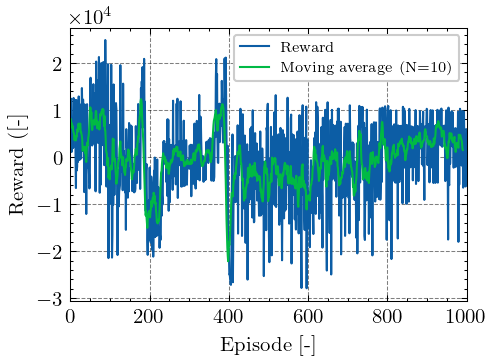

In [468]:
log = EventLog('../exploration/runs/experiment_1/')
step, reward = log.extract_scalar('Reward/Episode')

moving_avg = np.convolve(reward, np.ones(10)/10, mode='valid')
# reward[115] = 1.01233 * reward[114]
plt.plot(step, reward, label='Reward')
plt.plot(step[0:991], moving_avg, label='Moving average (N=10)')
# plt.ylim(top=100)
plt.xlim(0, 1000)
plt.legend(fontsize=7)
plt.xlabel("Episode [-]")
plt.ylabel("Reward ([-]")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.savefig("reward.pdf")
plt.show()

In [146]:
def cartesian_to_track(x):
    x_copy = x.copy()
    x_copy += np.array([0, 0, R_E])
    # x axis = forward...
    # y axis = left...
    r = np.linalg.norm(x_copy)
    
    theta   =  np.arctan(x_copy[0]/x_copy[2])
    phi   =  np.arcsin(x_copy[1]/r)
    
    return np.array([theta * R_E, -phi * R_E])

print(x[0, 8:-7].shape)
tasks_reshaped = data['x'][:, 8:-10].reshape(500, 7, 3)
task_tracks = [cartesian_to_track(x) for x in tasks_reshaped[0, :, :]]

for x in task_tracks:
    plt.plot(x[1], x[0], 'o')

plt.show()

(24,)


ValueError: cannot reshape array of size 4200 into shape (500,7,3)

In [448]:
# Helper functions
def v_orb(h):
        return np.sqrt(mu / (h + R_E))

def intersect_ray_sphere(P, u, x0, r):
    """
    Determines the intersections of a ray with a sphere.
    
    Parameters:
    P (numpy array): The starting point of the ray (3D vector).
    u (numpy array): The direction of the ray (3D vector).
    x0 (numpy array): The center of the sphere (3D vector).
    r (float): The radius of the sphere.
    
    Returns:
    t1, t2 (float, float): The parameter values at which the intersections occur.
    None if there are no intersections.
    """
    # Normalize direction vector
    u = u / torch.norm(u)
    
    # Compute coefficients of the quadratic equation
    A = torch.dot(u, u)
    B = 2 * torch.dot(u, P - x0)
    C = torch.dot(P - x0, P - x0) - r**2
    
    # Compute the discriminant
    discriminant = B**2 - 4*A*C
    
    if discriminant < 0:
        # No intersection
        return None
    elif discriminant == 0:
        # One intersection (tangent)
        t = -B / (2*A)
        return (P + t * u,)
    else:
        # Two intersections
        sqrt_disc = torch.sqrt(discriminant)
        t1 = (-B + sqrt_disc) / (2*A)
        t2 = (-B - sqrt_disc) / (2*A)
        return (P + t1 * u, P + t2 * u, t1, t2)
    
def earth_line_intersection(P, u):
    p = intersect_ray_sphere(P, u, torch.tensor([0, 0, -R_E]), R_E)
    if(p is None):
        return p
    else:
        p1, p2, t1, t2 = p
        if(t1 < 0 and t2 < 0):
            return (p1, p2)
        else:
            return None

def qdot_matrix(q):
    qw, qx, qy, qz = q
    return torch.tensor([
        [-qx, -qy, -qz],
        [qw, -qz, qy],
        [qz, qw, -qx],
        [-qy, qx, qw]
    ])

def qdot(q, w):
    return 0.5 * qdot_matrix(q) @ w

def euler_eqn(w, u, J, Jinv):
    return Jinv @ (u - torch.cross(w, J @ w))

def xdot(x, u, J, Jinv):
    w = x[:3]
    q = x[3:]

    w_dot = euler_eqn(w, u, J, Jinv)
    q_dot = qdot(q, w)

    return torch.cat([w_dot, q_dot])

def q2mat(q, homogenous=False):
    w, x, y, z = q
    if(not homogenous):
        return torch.tensor([
            [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
            [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
            [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
        ])
    return torch.tensor([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w, 0],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w, 0],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2, 0],
        [0, 0, 0, 1]
    ])

def eul2q(yaw, pitch, roll):
    # Calculate the half angles
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)

    # Calculate the quaternion
    w = cr * cp * cy + sr * sp * sy
    x = sr * cp * cy - cr * sp * sy
    y = cr * sp * cy + sr * cp * sy
    z = cr * cp * sy - sr * sp * cy

    return (w, x, y, z)

def eul2R(roll, pitch, yaw):
    
    # Calculate rotation matrix for roll (around x-axis)
    R_x = torch.tensor([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])
    
    # Calculate rotation matrix for pitch (around y-axis)
    R_y = torch.tensor([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Calculate rotation matrix for yaw (around z-axis)
    R_z = torch.tensor([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])
    
    # Combine the rotations
    R = R_z @ (R_y @ R_x)
    
    return R

def get_intrinsics(f, c_x, c_y):
    K = torch.hstack([torch.tensor([-f, 0, c_x, 0, -f, c_y, 0, 0, 1]).reshape(3,3), torch.zeros((3,1))])
    return K

def get_camera_rotation(q):
    R_q = q2mat(q).float()
    R_0 = eul2R(0, torch.pi, -torch.pi/2).float() # boresight on -z
    R = R_q @ R_0
    return R

def get_extrinsics(q, p):
    R = get_camera_rotation(q)
    t = -R @ p
    bottom_row = torch.tensor([[0, 0, 0, 1]])
    Rt = torch.cat((R, t.reshape(3, 1)), dim=1)
    transformation_matrix = torch.cat((Rt, bottom_row), dim=0)
    return transformation_matrix



def get_camera_matrix(K, q, p):
    return K @ get_extrinsics(q, p).float()

def task_from_track(across, along):
    print(f"across: {across}, along: {along}")
    theta = along / R_E
    phi = across / R_E

    return torch.tensor([R_E * np.sin(theta), R_E * np.cos(theta) * np.sin(phi), R_E * (np.cos(theta) * np.cos(phi) - 1)])

def get_model_weights_norm(model):
    """
    Calculate the norm of the weights of a PyTorch model.

    Args:
    model (nn.Module): The PyTorch model.

    Returns:
    float: The norm of the weights.
    """
    total_norm = 0.0
    for param in model.parameters():
        param_norm = param.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    
    return total_norm

def get_model_grad_norm(model):
    """
    Calculate the norm of the gradients of a PyTorch model.

    Args:
    model (nn.Module): The PyTorch model.

    Returns:
    float: The norm of the gradients.
    """
    total_norm = 0.0
    for param in model.parameters():
        param_norm = param.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    
    return total_norm

def get_corner_vectors(K, q, width, height):
    corners = torch.tensor([[0, 0, 1], [width, 0, 1], [0, height, 1], [width, height, 1]]).float()
    corners_world = [get_camera_rotation(q).T @ torch.linalg.inv(K[:, :3]) @ x for x in corners]
    return torch.stack(corners_world)

def get_corner_track(K, q, width, height, h=400):
    corners_world = get_corner_vectors(K, q, width, height)
    intersections = [earth_line_intersection(torch.tensor([0, 0, h]).float(), -x) for x in corners_world]
    return [cartesian_to_track(x[0].numpy()) for x in intersections if x is not None]

def get_center_vector(K, q, width, height):
    center = torch.tensor([width/2, height/2, 1]).float()
    center_world = get_camera_rotation(q).T @ torch.linalg.inv(K[:, :3]) @ center
    return center_world

def get_center_track(K, q, width, height, h=400):
    center_world = get_center_vector(K, q, width, height)
    intersections = earth_line_intersection(torch.tensor([0, 0, h]).float(), -center_world)
    if (intersections is None):
        return None
    
    return cartesian_to_track(intersections[0].numpy())

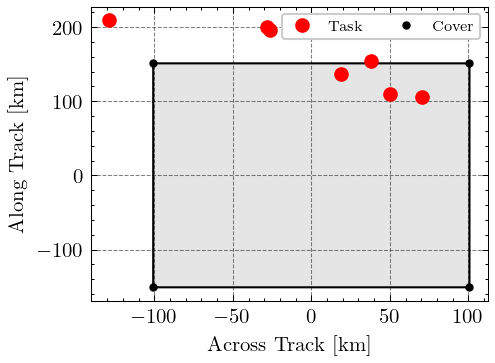

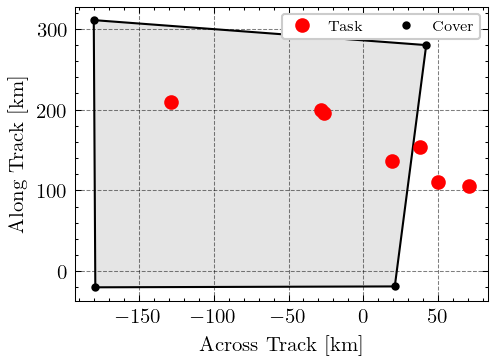

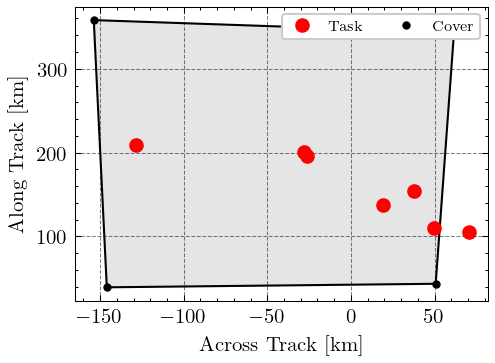

In [536]:
# Plot ground track...
# 110, 390, etc
ep = 390
data = np.load(f'../exploration/final_2_{ep}.npz')
x = data['x']
u= data['u']

q0 = x[:, 3:7]

h = 400
width = 1200
height = 800
import torch
dt = 0.1
mu = 398600
track_points = []
for i, q in enumerate(q0):
    # print(i)
    intersection = earth_line_intersection(torch.tensor([0, 0, h]).double(), q2mat(q) @ torch.tensor([0, 0, 1]).double())
    v_t = v_orb(h) * (1 - (h/R_E))

    if intersection is not None:
        track_point = cartesian_to_track(intersection[0].numpy())
        # print(np.linalg.norm(np.array(track_points[-1]) - np.array(track_point)))
        # elif(np.linalg.norm(np.array(track_points[-1]) - np.array(track_point)) < 10000):
        # print(track_point[0])
        track_point[0] += v_t * dt * i 
        # track_point[0] *= -1
        # print(track_point[0])
        track_points.append(track_point)

        # track_points.append(track_point)
        # print(track_point)
        # Remember to move points F0RWARD by amount of time

# plt.plot([x[1] for x in track_points], [x[0] for x in track_points])



K = get_intrinsics(1600, width/2, height/2)
M = get_camera_matrix(K, torch.tensor([1, 0, 0, 0]), torch.tensor([0, 0, h]).float())
p = torch.tensor([0, 0, h]).float()

for N in [0, 100, 199]:
    plt.figure()
# N = 150
    task_plots = []
    for x in task_tracks:
        task_plots.append(plt.plot(x[1], x[0], 'ro'))
    
    q = q0[N]
    i = data['x'][N, 7]/dt - 1

    corner_plots = []
    corners = np.array(get_corner_track(K, q, width, height))
    corners[:, 1] += v_t * i * dt
    corners[:, 0] *= -1
    plt.plot(corners[:, 0], corners[:, 1], 'k.', label='Cover')
    cover_patch = plt.Polygon(corners[[0, 1, 3, 2]][:, [0, 1]], edgecolor='black', facecolor=[0, 0, 0, 0.1])
    plt.gca().add_patch(cover_patch)
    # for x in corners:
        # corner_plots.append(plt.plot(-x[0], x[1] + v_t * i * dt, 'k.', label=''))
    
    task_plots[0][0].set_label('Task')   

    plt.legend(fontsize=7, loc='upper right', ncol=2)
    plt.xlabel('Across Track [km]')
    plt.ylabel('Along Track [km]')
    plt.tight_layout()
    plt.savefig(f"track_{ep}_{N}.pdf")
    plt.show()

# for i, q in enumerate(q0):
# for i, q in enumerate(q0):
#     x = get_center_track(K, q, width, height)
#     plt.plot(-x[0], x[1] + v_t * i * dt, 'k.')

# corner_track = get_corner_track(M, width, height)
# print(corner_track / corner_track[:, -1])


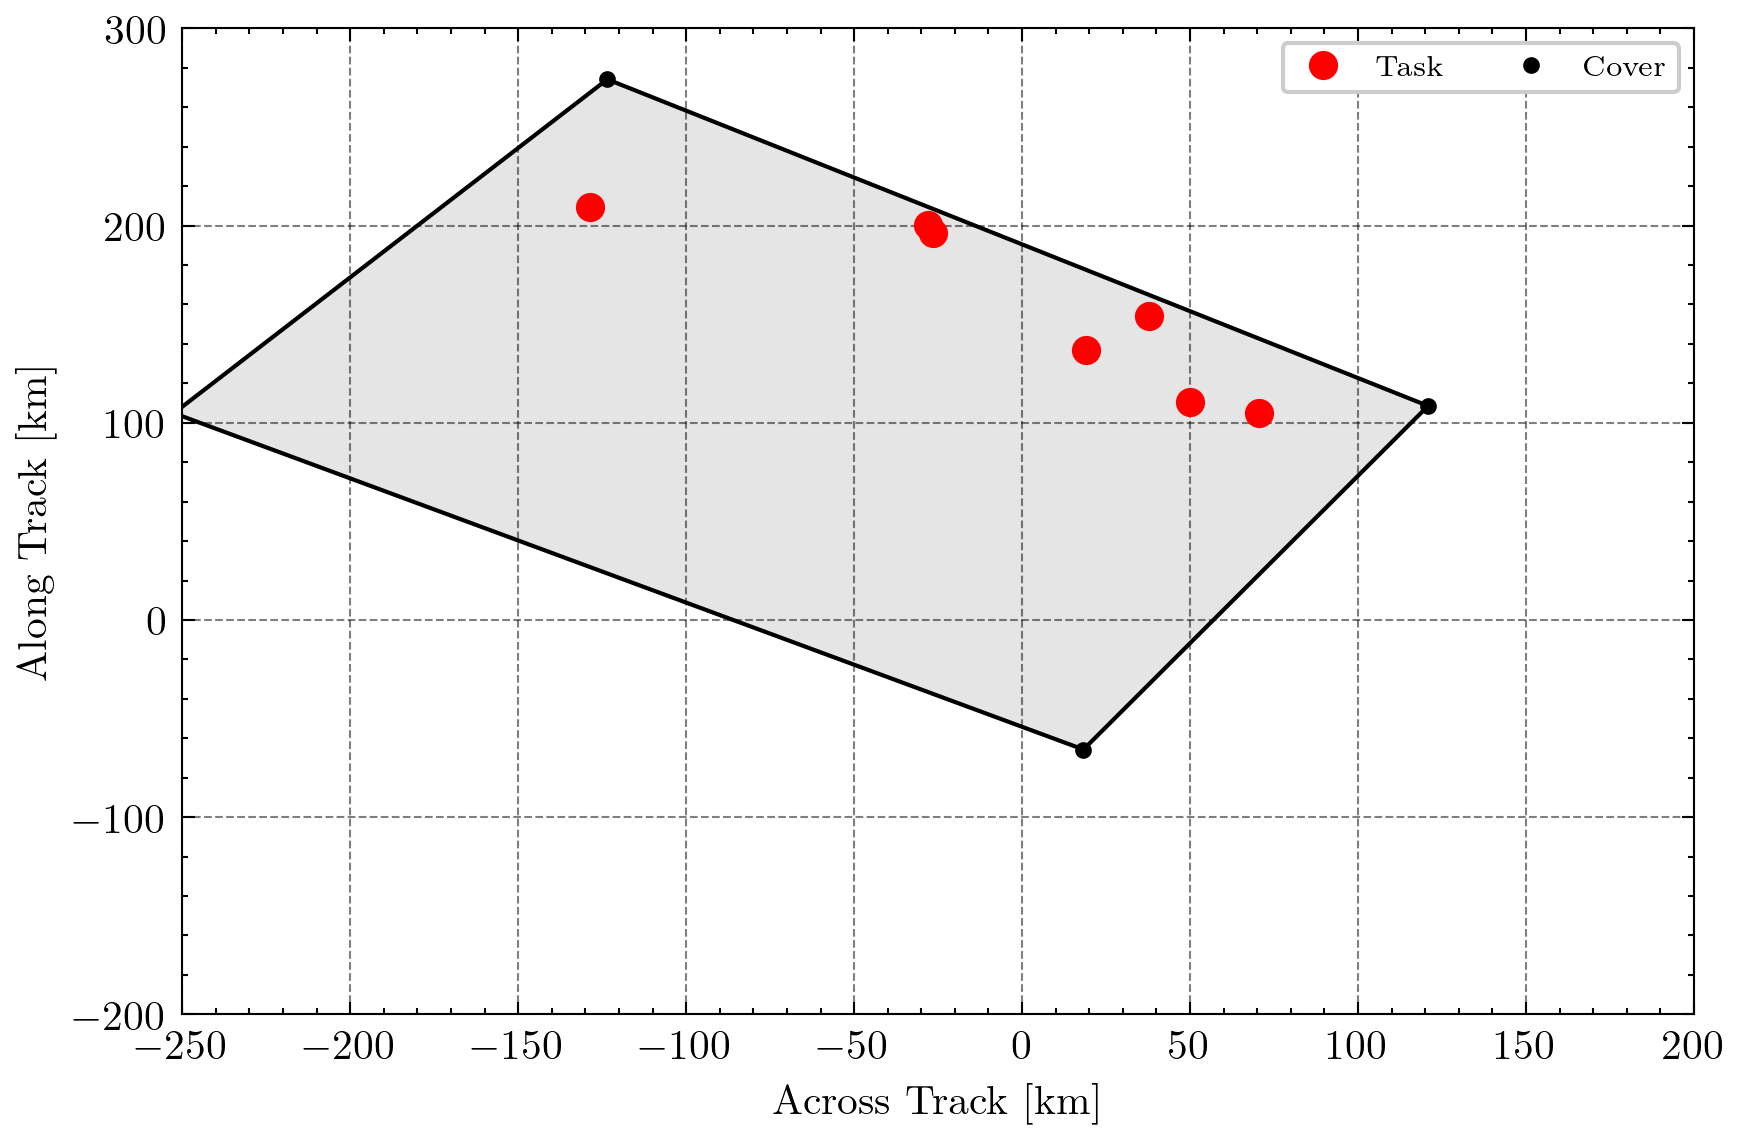

In [533]:
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\shree\\Downloads\\ffmpeg-2024-07-28-git-e7d3ff8dcd-essentials_build\\bin\\ffmpeg.exe'

ep = 110
data = np.load(f'../exploration/final_2_{ep}.npz')
x = data['x']
u = data['u']
q0 = x[:, 3:7]

# Constants
h = 400
width = 1200
height = 800
dt = 0.1
mu = 398600

# Calculate track points
track_points = []
for i, q in enumerate(q0):
    intersection = earth_line_intersection(torch.tensor([0, 0, h]).double(), q2mat(q) @ torch.tensor([0, 0, 1]).double())
    v_t = v_orb(h) * (1 - (h / R_E))

    if intersection is not None:
        track_point = cartesian_to_track(intersection[0].numpy())
        track_point[0] += v_t * dt * i
        track_points.append(track_point)

# Prepare camera matrix and intrinsic parameters
K = get_intrinsics(1600, width / 2, height / 2)
M = get_camera_matrix(K, torch.tensor([1, 0, 0, 0]), torch.tensor([0, 0, h]).float())
p = torch.tensor([0, 0, h]).float()

fig, ax = plt.subplots(dpi=300, figsize=(6, 4))
task_plots = []
corner_plots = []

def update(N):
    ax.clear()
    ax.set_ylim(-200, 300)
    ax.set_xlim(-250, 200)
    # ax.set_ylim(-200, 400)
    # ax.set_xlim(-250, 200)
    task_plots.clear()
    corner_plots.clear()
    
    # Plot task tracks
    for x in task_tracks:
        task_plots.append(ax.plot(x[1], x[0], 'ro'))
    
    q = q0[N]
    i = data['x'][N, 7] / dt - 1

    corners = np.array(get_corner_track(K, q, width, height))
    corners[:, 1] += v_t * i * dt
    corners[:, 0] *= -1
    ax.plot(corners[:, 0], corners[:, 1], 'k.', label='Cover')
    cover_patch = plt.Polygon(corners[[0, 1, 3, 2]][:, [0, 1]], edgecolor='black', facecolor=[0, 0, 0, 0.1])
    ax.add_patch(cover_patch)
    
    task_plots[0][0].set_label('Task')
    
    ax.legend(fontsize=7, loc='upper right', ncol=2)
    ax.set_xlabel('Across Track [km]')
    ax.set_ylabel('Along Track [km]')
    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=range(0, len(q0), 1), repeat=False)
ani.save(f"{ep}_track.mp4", writer='ffmpeg',fps=30, dpi=150)
plt.show()

In [520]:
# Export to Blender

['pillow', 'html']

In [534]:
def trajectory2blender(x, newfilename="animation.blend", render=False):
    import bpy

    q = x[:, 3:]
    frame_step = 1

    bpy.ops.wm.open_mainfile(filepath="cubesat_model.blend")

    bpy.data.objects["Cube.003"].rotation_mode = 'QUATERNION'
    for i in range(x.shape[0]):
        bpy.data.objects['Cube.003'].rotation_quaternion = q[i, :]
        bpy.data.objects['Cube.003'].keyframe_insert(data_path="rotation_quaternion", frame=int(i * frame_step))

    bpy.context.scene.frame_end = int(x.shape[0] * frame_step)

    if(render):
        bpy.context.scene.render.filepath = f"/tmp/{newfilename}.mkv"
        bpy.ops.render.render(animation=True)   
        
    bpy.ops.wm.save_as_mainfile(filepath=newfilename)


In [538]:
ep = 390
data = np.load(f'../exploration/final_2_{ep}.npz')
x = data['x']
trajectory2blender(x[:, :7], newfilename=f"{ep}_trajectory", render=True)

Info: Saved "390_trajectory"
